# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [ ]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [ ]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 15
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([15, 224, 224, 3])
tensor([12,  5, 12,  3,  1, 12, 12,  1,  0,  0,  0, 12, 12, 12, 12, 12, 12, 12,
        12,  0, 12, 12, 12, 12, 12, 12,  2, 12,  2,  7, 12,  0, 12, 12, 12, 12,
         6, 12, 12,  6, 12, 12, 12, 12,  7, 12,  6, 12,  6,  6,  6, 12, 12, 12,
        12, 12, 12, 11,  9, 12, 10, 12, 12, 12])
tensor([[12,  5, 12,  3,  1, 12, 12,  1],
        [ 0,  0,  0, 12, 12, 12, 12, 12],
        [12, 12, 12,  0, 12, 12, 12, 12],
        [12, 12,  2, 12,  2,  7, 12,  0],
        [12, 12, 12, 12,  6, 12, 12,  6],
        [12, 12, 12, 12,  7, 12,  6, 12],
        [ 6,  6,  6, 12, 12, 12, 12, 12],
        [12, 11,  9, 12, 10, 12, 12, 12]])


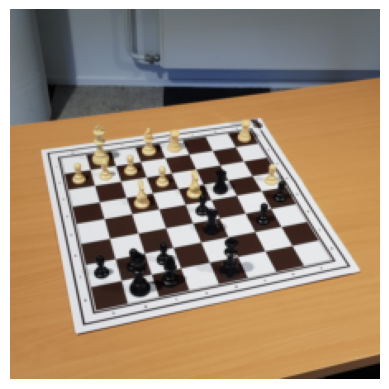

torch.Size([15, 224, 224, 3])
tensor([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0, 12,  0, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  8,  9, 11, 10,  9,  8,  7])
tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0, 12,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12,  0, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]])


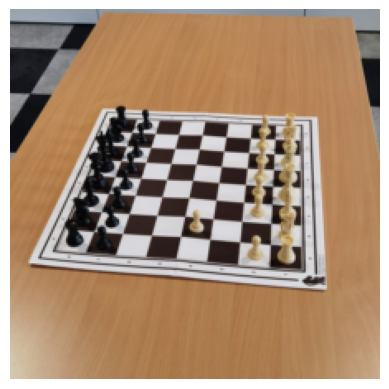

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[1])
    print(labels[1].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def calculate_chess_accuracy(y_true, y_pred):
    """
    Calculate chess board accuracy metrics
    Args:
        y_true: Ground truth (batch_size, 64)
        y_pred: Model predictions (batch_size, 64)
    Returns:
        overall_acc: Total accuracy across all squares
        square_acc: List of accuracies per square
    """
    # Convert -0 to 0 (equivalent in floating point)
    y_true = np.where(y_true == -0., 0., y_true)
    y_pred = np.where(y_pred == -0., 0., y_pred)
    
    # Binarize predictions if using raw outputs
    y_pred = (y_pred > 0.5).astype(float)
    
    # Calculate overall accuracy (all squares combined)
    overall_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    # Calculate accuracy per square
    square_acc = []
    for square_idx in range(64):
        acc = accuracy_score(y_true[:, square_idx], y_pred[:, square_idx])
        square_acc.append(acc)
    
    return overall_acc, square_acc

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    # Suggested fix:
    matches = (all_preds == all_labels).cpu().numpy()
    accuracy = np.mean(matches) * 100
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [12]:
test = [1, 2, 3]
test1 = [1, 0, 0]

# Create boolean array of matches
condition_array = np.array(test) == np.array(test1)

# Calculate percentage of correct elements
percentage_correct = np.mean(condition_array) * 100

print("Matching elements array:", condition_array)
print(f"Percentage correct: {percentage_correct:.1f}%")

Matching elements array: [ True False False]
Percentage correct: 33.3%


Define loss, optimizer and train the model

In [13]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 431/431 [02:10<00:00,  3.30it/s]


Train loss: 12.90948 	 Train acc: 14.07338


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 11.65100 	 Val acc: 22.62417

Epoch 2


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 11.88454 	 Train acc: 16.65579


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 11.75300 	 Val acc: 19.23115

Epoch 3


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 10.94669 	 Train acc: 20.53896


100%|██████████| 147/147 [00:13<00:00, 10.50it/s]


Val loss: 11.01313 	 Val acc: 22.27347

Epoch 4


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 9.55445 	 Train acc: 26.09025


100%|██████████| 147/147 [00:14<00:00, 10.50it/s]


Val loss: 10.38154 	 Val acc: 32.84173

Epoch 5


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 8.10791 	 Train acc: 32.80332


100%|██████████| 147/147 [00:14<00:00, 10.50it/s]


Val loss: 10.10063 	 Val acc: 34.93242

Epoch 6


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 6.70513 	 Train acc: 40.07009


100%|██████████| 147/147 [00:13<00:00, 10.50it/s]


Val loss: 10.31012 	 Val acc: 34.97805

Epoch 7


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 5.56596 	 Train acc: 45.84300


100%|██████████| 147/147 [00:13<00:00, 10.51it/s]


Val loss: 9.72947 	 Val acc: 38.97839

Epoch 8


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 4.64709 	 Train acc: 50.72216


100%|██████████| 147/147 [00:13<00:00, 10.50it/s]


Val loss: 9.75996 	 Val acc: 41.78903

Epoch 9


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 4.03359 	 Train acc: 53.82226


100%|██████████| 147/147 [00:13<00:00, 10.51it/s]


Val loss: 9.76175 	 Val acc: 44.45355

Epoch 10


100%|██████████| 431/431 [02:09<00:00,  3.32it/s]


Train loss: 3.56192 	 Train acc: 56.63670


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 9.36653 	 Val acc: 45.32105

Epoch 11


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 3.15055 	 Train acc: 59.01634


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 9.46825 	 Val acc: 44.92330

Epoch 12


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 2.86045 	 Train acc: 60.61074


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 9.35450 	 Val acc: 47.87794

Epoch 13


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 2.64288 	 Train acc: 61.80733


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 9.33332 	 Val acc: 47.05677

Epoch 14


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 2.39037 	 Train acc: 63.54384


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 9.12993 	 Val acc: 46.73529

Epoch 15


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 2.21324 	 Train acc: 64.49584


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 9.20168 	 Val acc: 47.73252

Epoch 16


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 2.06726 	 Train acc: 65.51092


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.83357 	 Val acc: 52.06076

Epoch 17


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.93755 	 Train acc: 66.14124


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.94848 	 Val acc: 47.11736

Epoch 18


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.81601 	 Train acc: 66.83222


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.85393 	 Val acc: 49.42618

Epoch 19


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.71604 	 Train acc: 67.43547


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.87311 	 Val acc: 50.17393

Epoch 20


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.65298 	 Train acc: 67.69262


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.74726 	 Val acc: 49.65713

Epoch 21


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.54119 	 Train acc: 68.61683


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 8.71870 	 Val acc: 49.37343

Epoch 22


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.46295 	 Train acc: 69.07990


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.62860 	 Val acc: 49.19238

Epoch 23


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.37591 	 Train acc: 69.71288


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.59916 	 Val acc: 48.71336

Epoch 24


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.33428 	 Train acc: 69.98912


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 8.53604 	 Val acc: 51.34295

Epoch 25


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.25100 	 Train acc: 70.69557


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.48298 	 Val acc: 53.21980

Epoch 26


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.25871 	 Train acc: 70.38887


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.55778 	 Val acc: 49.99572

Epoch 27


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.19047 	 Train acc: 71.11345


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.60743 	 Val acc: 49.00134

Epoch 28


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.09627 	 Train acc: 71.82280


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.54067 	 Val acc: 49.99002

Epoch 29


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.08526 	 Train acc: 71.88733


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.42845 	 Val acc: 51.16118

Epoch 30


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 1.03354 	 Train acc: 72.44900


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.35406 	 Val acc: 50.04918

Epoch 31


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.98784 	 Train acc: 72.75667


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.39454 	 Val acc: 51.28878

Epoch 32


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.96130 	 Train acc: 73.06119


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.41561 	 Val acc: 49.57231

Epoch 33


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.94183 	 Train acc: 73.19606


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.31440 	 Val acc: 51.15548

Epoch 34


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.91789 	 Train acc: 73.38844


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.38225 	 Val acc: 49.46681

Epoch 35


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.87369 	 Train acc: 73.78311


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.23109 	 Val acc: 51.00721

Epoch 36


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.85760 	 Train acc: 74.04582


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.28662 	 Val acc: 49.44186

Epoch 37


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.83839 	 Train acc: 74.15458


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 8.30122 	 Val acc: 50.27372

Epoch 38


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.80155 	 Train acc: 74.65656


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.10985 	 Val acc: 51.92461

Epoch 39


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.79795 	 Train acc: 74.59010


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.10736 	 Val acc: 50.91241

Epoch 40


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.77098 	 Train acc: 74.96109


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.16128 	 Val acc: 51.58103

Epoch 41


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.74720 	 Train acc: 75.11915


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.92656 	 Val acc: 52.21758

Epoch 42


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.71002 	 Train acc: 75.64675


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.06296 	 Val acc: 51.80557

Epoch 43


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.70804 	 Train acc: 75.65449


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.01642 	 Val acc: 51.80201

Epoch 44


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.68587 	 Train acc: 75.88505


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.12624 	 Val acc: 51.25527

Epoch 45


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.67065 	 Train acc: 76.13931


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.02341 	 Val acc: 51.05141

Epoch 46


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.68030 	 Train acc: 75.90294


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.05673 	 Val acc: 51.23246

Epoch 47


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.65653 	 Train acc: 76.32492


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.01151 	 Val acc: 50.67932

Epoch 48


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.62078 	 Train acc: 76.81458


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 8.04611 	 Val acc: 50.82687

Epoch 49


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.60023 	 Train acc: 77.07342


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 8.02605 	 Val acc: 50.47117

Epoch 50


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.57808 	 Train acc: 77.66024


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 8.00549 	 Val acc: 51.43134

Epoch 51


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.58519 	 Train acc: 77.35281


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.05425 	 Val acc: 50.14755

Epoch 52


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.58060 	 Train acc: 77.43668


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.97894 	 Val acc: 50.09338

Epoch 53


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.56944 	 Train acc: 77.50943


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.96058 	 Val acc: 50.90457

Epoch 54


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.55678 	 Train acc: 77.81298


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 8.00274 	 Val acc: 49.71559

Epoch 55


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.56776 	 Train acc: 77.57396


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.90934 	 Val acc: 50.93237

Epoch 56


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.54673 	 Train acc: 77.88476


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.82905 	 Val acc: 50.69928

Epoch 57


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.51624 	 Train acc: 78.31061


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.88853 	 Val acc: 50.36283

Epoch 58


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.51044 	 Train acc: 78.48076


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.73877 	 Val acc: 51.31373

Epoch 59


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.49666 	 Train acc: 78.77489


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.78956 	 Val acc: 51.25741

Epoch 60


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.49656 	 Train acc: 78.85828


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.81097 	 Val acc: 51.10772

Epoch 61


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.49259 	 Train acc: 78.94673


100%|██████████| 147/147 [00:14<00:00, 10.49it/s]


Val loss: 7.80493 	 Val acc: 51.01933

Epoch 62


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.48423 	 Train acc: 79.00643


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.74624 	 Val acc: 50.85752

Epoch 63


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.48619 	 Train acc: 78.95447


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.74100 	 Val acc: 50.36924

Epoch 64


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.47733 	 Train acc: 79.24256


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.77870 	 Val acc: 51.08705

Epoch 65


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.46668 	 Train acc: 79.42865


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.78461 	 Val acc: 51.31444

Epoch 66


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.44879 	 Train acc: 79.84846


100%|██████████| 147/147 [00:14<00:00, 10.45it/s]


Val loss: 7.77664 	 Val acc: 51.00721

Epoch 67


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.44608 	 Train acc: 79.89245


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.71080 	 Val acc: 50.92168

Epoch 68


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.44265 	 Train acc: 79.97776


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.71751 	 Val acc: 51.00793

Epoch 69


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.44618 	 Train acc: 79.80158


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.76122 	 Val acc: 51.19255

Epoch 70


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.44040 	 Train acc: 80.04592


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.68482 	 Val acc: 51.37004

Epoch 71


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.43363 	 Train acc: 80.19383


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.67984 	 Val acc: 50.75630

Epoch 72


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.41965 	 Train acc: 80.42392


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.70292 	 Val acc: 50.76984

Epoch 73


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.42915 	 Train acc: 80.21123


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.72074 	 Val acc: 51.35008

Epoch 74


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.43348 	 Train acc: 80.18900


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.73901 	 Val acc: 51.26882

Epoch 75


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.40369 	 Train acc: 80.85484


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.56151 	 Val acc: 51.05782

Epoch 76


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.38899 	 Train acc: 81.27852


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.60509 	 Val acc: 51.96097

Epoch 77


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.38557 	 Train acc: 81.31115


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.61687 	 Val acc: 50.51751

Epoch 78


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.39207 	 Train acc: 81.27538


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.71521 	 Val acc: 50.67718

Epoch 79


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.39049 	 Train acc: 81.27151


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.61085 	 Val acc: 51.18827

Epoch 80


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.38548 	 Train acc: 81.30293


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.63219 	 Val acc: 50.53176

Epoch 81


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.39460 	 Train acc: 81.19925


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.63471 	 Val acc: 50.13045

Epoch 82


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.38733 	 Train acc: 81.30365


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.69082 	 Val acc: 50.10122

Epoch 83


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.37581 	 Train acc: 81.61905


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.56883 	 Val acc: 50.50539

Epoch 84


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.36464 	 Train acc: 81.97820


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.69763 	 Val acc: 50.17963

Epoch 85


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.36946 	 Train acc: 81.76479


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.68028 	 Val acc: 50.53533

Epoch 86


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.36074 	 Train acc: 82.03596


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.62024 	 Val acc: 50.55600

Epoch 87


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.37743 	 Train acc: 81.63428


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.58376 	 Val acc: 50.96444

Epoch 88


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.36423 	 Train acc: 81.94340


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.63181 	 Val acc: 50.79836

Epoch 89


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.35715 	 Train acc: 82.18653


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.62517 	 Val acc: 50.77341

Epoch 90


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.35216 	 Train acc: 82.19523


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.61783 	 Val acc: 50.31507

Epoch 91


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33694 	 Train acc: 82.62544


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.57936 	 Val acc: 51.30945

Epoch 92


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33985 	 Train acc: 82.62060


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.66858 	 Val acc: 50.84113

Epoch 93


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33498 	 Train acc: 82.71800


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.55702 	 Val acc: 50.73919

Epoch 94


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33015 	 Train acc: 82.86495


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.60965 	 Val acc: 51.99019

Epoch 95


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33018 	 Train acc: 82.90386


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.62472 	 Val acc: 50.02994

Epoch 96


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.34009 	 Train acc: 82.65250


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.58385 	 Val acc: 50.12902

Epoch 97


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33626 	 Train acc: 82.87872


100%|██████████| 147/147 [00:14<00:00, 10.48it/s]


Val loss: 7.61464 	 Val acc: 50.76699

Epoch 98


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.33081 	 Train acc: 83.02470


100%|██████████| 147/147 [00:14<00:00, 10.46it/s]


Val loss: 7.66303 	 Val acc: 50.83329

Epoch 99


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.31908 	 Train acc: 83.27557


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.62914 	 Val acc: 50.74846

Epoch 100


100%|██████████| 431/431 [02:10<00:00,  3.31it/s]


Train loss: 0.31186 	 Train acc: 83.47980


100%|██████████| 147/147 [00:14<00:00, 10.47it/s]


Val loss: 7.55387 	 Val acc: 50.44337
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [14]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

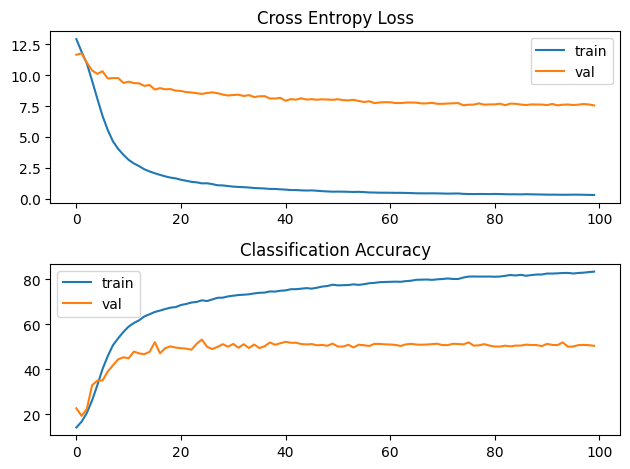

In [15]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [16]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        preds.extend(predsTmp.round().astype(int).squeeze())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu().detach().numpy()
        labels.extend(original_values)
    print(labels[:1],preds[:1])
    preds_np = np.array(preds)
    labels_np = np.array(labels)
    matches = (preds_np == labels_np)
    accuracy = np.mean(matches) * 100
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 142/142 [00:14<00:00,  9.87it/s]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])] [array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])]
Test loss: 47.867


  0%|          | 0/142 [00:00<?, ?it/s]

[[ 1.  2.  3.  5.  4.  3.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  8.  9. 11. 10.  9.  8.  7.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


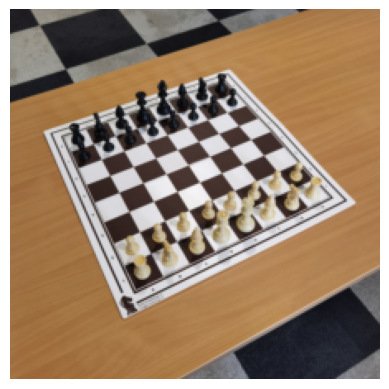

  0%|          | 0/142 [00:00<?, ?it/s]


In [17]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        print(predsTmp[0].round().reshape(8, 8))
        print(y.cpu()[0].reshape(8, 8).numpy())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?